In [1]:
import simulation
import utils
import HminLower
import shannonLower
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import json
import ShannonEAT
import cvxpy as cp
import chaospy
from scipy.special import betaincinv

## Comparing Hmin, Shannon 1 and 2 ouputs for all implementations


In [ ]:
res = {'diff': [], 'shannon': [], 'hmin': [], 'deltas': [], 'shannon2': []}
alphas = np.linspace(0.07, 2, 30)

for alpha in alphas:
    delta, p = simulation.getProbas(alpha, 1, 0, '1')
    hmin = HminLower.getHmin(p, delta, 1/2)
    shannon = shannonLower.runOpti(delta, p, 1/2)
    shannon2 = shannonLower.runOpti(delta, p, 1/2, 2)
    diff = shannon - hmin
    res['diff'].append(diff)
    res['shannon'].append(shannon)
    res['shannon2'].append(shannon2)
    res['hmin'].append(hmin)
    res['deltas'].append(delta)

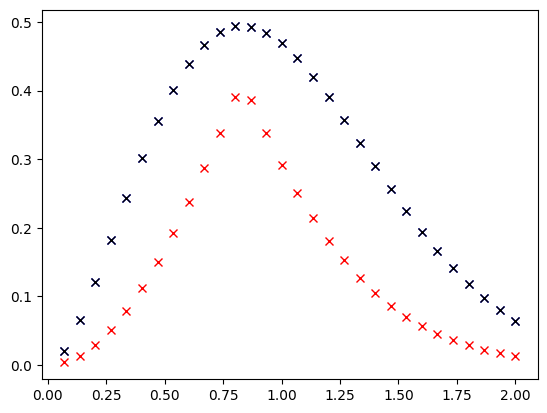

In [5]:
plt.figure()
plt.plot(alphas, res['shannon'], 'bx')
plt.plot(alphas, res['shannon2'], 'kx')
plt.plot(alphas, res['hmin'], 'rx')

### even impl 2 is equivalent for both bc at least wo errors, we either get b=x or b=inc -> it's like c 

In [ ]:
res = {'diff': [], 'shannon': [], 'hmin': [], 'deltas': [], 'shannon2': []}
alphas = np.linspace(0.07, 2, 30)

for alpha in alphas:
    delta, p = simulation.getProbas(alpha, 1, 0, '2')
    hmin = HminLower.getHmin(p, delta, 1/2)
    shannon = shannonLower.runOpti(delta, p, 1/2)
    shannon2 = shannonLower.runOpti(delta, p, 1/2, 2)
    diff = shannon - hmin
    res['diff'].append(diff)
    res['shannon'].append(shannon)
    res['shannon2'].append(shannon2)
    res['hmin'].append(hmin)
    res['deltas'].append(delta)

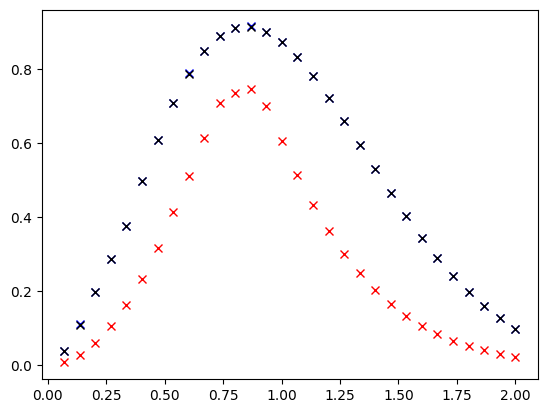

In [ ]:
plt.figure()
plt.plot(alphas, res['shannon'], 'bx')
plt.plot(alphas, res['shannon2'], 'kx')
plt.plot(alphas, res['hmin'], 'rx')

In [8]:
res = {'diff': [], 'shannon': [], 'hmin': [], 'deltas': [], 'shannon2': []}
alphas = np.linspace(0.07, 2, 30)

for alpha in alphas:
    delta, p = simulation.getProbas(alpha, 1, 0, '4')
    hmin = HminLower.getHmin(p, delta, 1/2)
    shannon = shannonLower.runOpti(delta, p, 1/2)
    shannon2 = shannonLower.runOpti(delta, p, 1/2, 2)
    diff = shannon - hmin
    res['diff'].append(diff)
    res['shannon'].append(shannon)
    res['shannon2'].append(shannon2)
    res['hmin'].append(hmin)
    res['deltas'].append(delta)

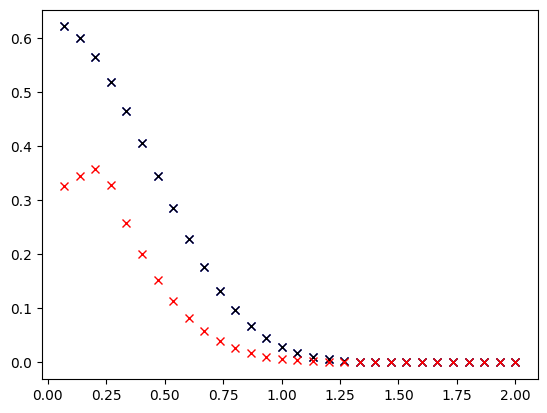

In [9]:
plt.figure()
plt.plot(alphas, res['shannon'], 'bx')
plt.plot(alphas, res['shannon2'], 'kx')
plt.plot(alphas, res['hmin'], 'rx')

In [17]:
res = {'diff': [], 'shannon': [], 'hmin': [], 'deltas': [], 'shannon2': [], 'shannon3' : [], 'deltas1': []}
alphas = np.linspace(0, 2, 50)

for alpha in alphas:
    delta, p = simulation.getProbas(alpha, 1, 0, '5', False, np.sqrt(2)*alpha)
    shannon = shannonLower.runOpti(delta, p, 1/2)
    shannon2 = shannonLower.runOpti(delta, p, 1/2, 2)
    res['shannon'].append(shannon)
    res['shannon2'].append(shannon2)
    res['deltas'].append(delta)
    delta, p = simulation.getProbas(alpha, 1, 0, '4')
    shannon3 = shannonLower.runOpti(delta, p, 1/2)
    res['shannon3'].append(shannon3)
    res['deltas1'].append(delta)


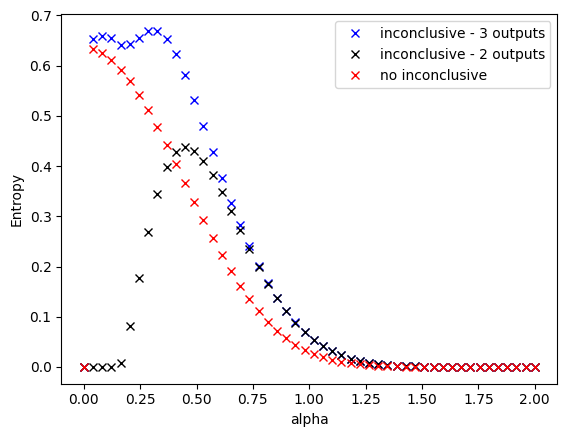

In [19]:
plt.figure()
plt.plot(alphas, res['shannon'], 'bx', label='inconclusive - 3 outputs')
plt.plot(alphas, res['shannon2'], 'kx', label='inconclusive - 2 outputs')
plt.plot(alphas, res['shannon3'], 'rx', label='no inconclusive')
plt.xlabel('alpha')
plt.ylabel('Entropy')
plt.legend()

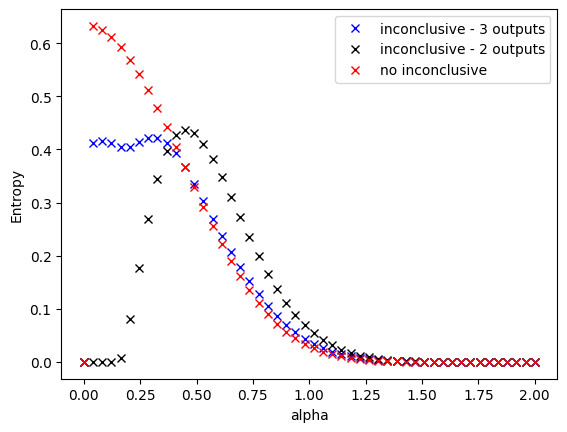

In [16]:
plt.figure()
plt.plot(alphas, res['shannon']/np.log2(3), 'bx', label='inconclusive - 3 outputs')
plt.plot(alphas, res['shannon2'], 'kx', label='inconclusive - 2 outputs')
plt.plot(alphas, res['shannon3'], 'rx', label='no inconclusive')
plt.xlabel('alpha')
plt.ylabel('Entropy')
plt.legend()

In [2]:
res = {'shannon': np.zeros((50,50)), 'hmin': np.zeros((50,50)), 'deltas': np.zeros((50,50)), 'shannon2': np.zeros((50,50))}
alphas = np.linspace(0, 4, 50)
ds = np.linspace(0, 4, 50)

for i, alpha in enumerate(alphas):
    for j, d in enumerate(ds): 
        delta, p = simulation.getProbas(alpha, 1, 0, '5', False, d)
        shannon = shannonLower.runOpti(delta, p, 1/2)
        shannon2 = shannonLower.runOpti(delta, p, 1/2, 2)
        res['shannon'][i][j] = (shannon)
        res['shannon2'][i][j] = (shannon2)
        res['deltas'][i][j] = (delta)


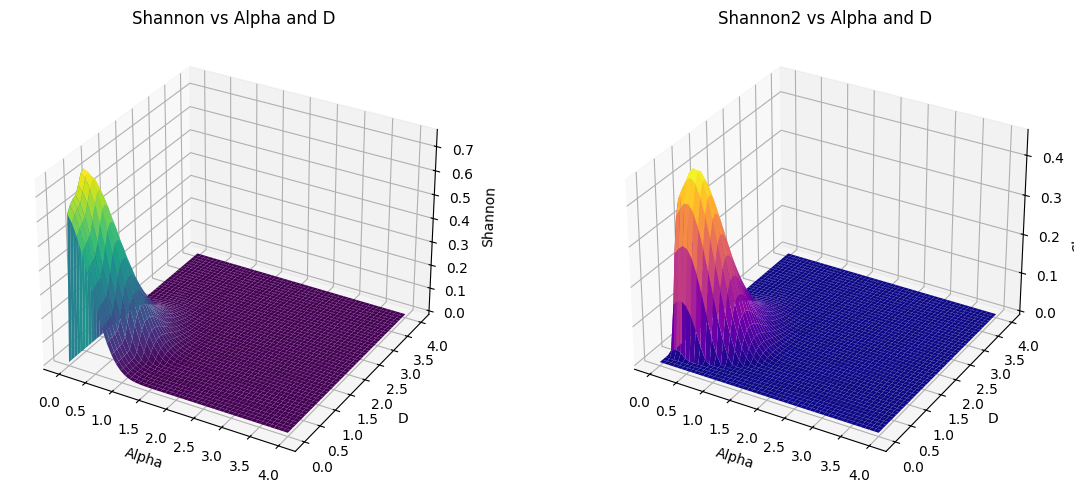

In [3]:
from mpl_toolkits.mplot3d import Axes3D

# Assume res, alphas, ds are already defined from your code
alphas = np.linspace(0, 4, 50)
ds = np.linspace(0, 4, 50)
A, D = np.meshgrid(alphas, ds)

fig = plt.figure(figsize=(18, 5))

# Plot shannon
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(A, D, res['shannon'].T, cmap='viridis')
ax1.set_title('Shannon vs Alpha and D')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('D')
ax1.set_zlabel('Shannon')

# Plot shannon2
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(A, D, res['shannon2'].T, cmap='plasma')
ax2.set_title('Shannon2 vs Alpha and D')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('D')
ax2.set_zlabel('Shannon2')

plt.tight_layout()
plt.show()


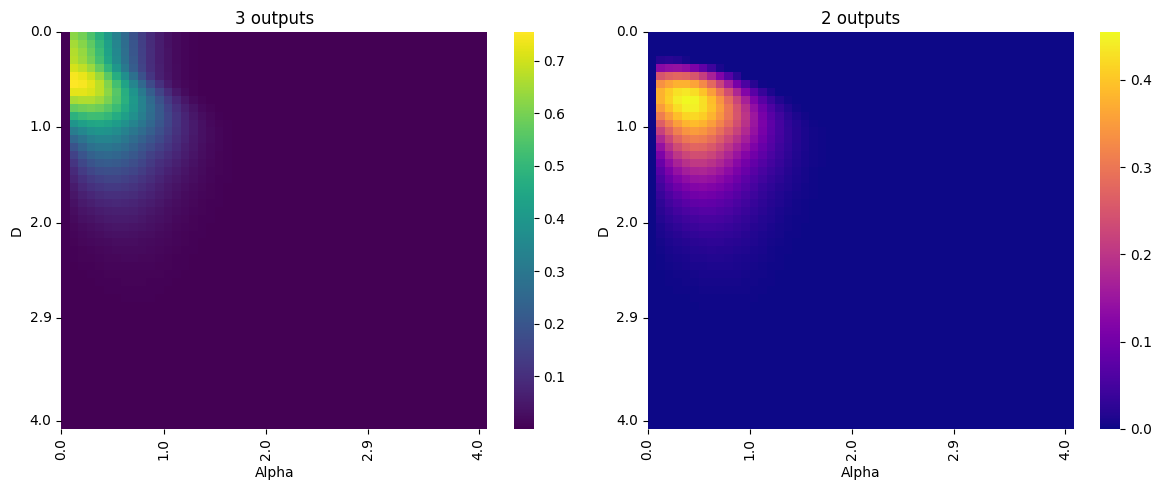

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Your alpha and d arrays
alphas = np.linspace(0, 4, 50)
ds = np.linspace(0, 4, 50)

# Convert arrays to DataFrames with proper indices
shannon_df = pd.DataFrame(res['shannon'], index=alphas, columns=ds)
shannon2_df = pd.DataFrame(res['shannon2'], index=alphas, columns=ds)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Shannon heatmap
sns.heatmap(shannon_df.T, ax=axs[0], cmap='viridis')
axs[0].set_title('3 outputs')
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('D')

# Shannon2 heatmap
sns.heatmap(shannon2_df.T, ax=axs[1], cmap='plasma')
axs[1].set_title('2 outputs')
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('D')

# Format axis ticks to 1 decimal
def format_ticks(ax, values, axis='x', nticks=5):
    idxs = np.linspace(0, len(values) - 1, nticks, dtype=int)
    labels = [f'{values[i]:.1f}' for i in idxs]
    if axis == 'x':
        ax.set_xticks(idxs)
        ax.set_xticklabels(labels)
    else:
        ax.set_yticks(idxs)
        ax.set_yticklabels(labels)

for ax in axs:
    format_ticks(ax, alphas, axis='x')
    format_ticks(ax, ds, axis='y')

plt.tight_layout()
plt.show()


## Comparing Shannon and EAT

In [ ]:
res1e3 = {'deltas': [], 'vals': [], 'theos': []}
alphas = np.linspace(0.07, 6, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    delta, p = simulation.getProbas(alpha, 0.77, 0, '1', False)
    H_theo, lambdas, Rs, cm = shannonLower.getHDual(delta, p, 7/8)
    res1e3['theos'].append(H_theo)
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 1000, 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH3(ps, 1000, lambdas, Rs, cm)
    res1e3['vals'].append(val)
    res1e3['deltas'].append(delta)

In [ ]:
res1e4 = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    delta, p = simulation.getProbas(alpha, 0.77, 0, '1', False)
    H_theo, lambdas, Rs, cm = shannonLower.getHDual(delta, p, 7/8)
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 10000, 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH3(ps, 10000, lambdas, Rs, cm)
    res1e4['vals'].append(val)
    res1e4['deltas'].append(delta)

In [ ]:
res1e5 = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    delta, p = simulation.getProbas(alpha, 0.77, 0, '1', False)
    H_theo, lambdas, Rs, cm = shannonLower.getHDual(delta, p, 7/8)
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH3(ps, 100000, lambdas, Rs, cm)
    res1e5['vals'].append(val)
    res1e5['deltas'].append(delta)

In [ ]:
alphas = [sqrt(alpha) for alpha in alphas]

In [ ]:
plt.figure()
plt.plot(alphas, res1e3['vals'], 'rx', label='ShannonEAT - No Deadtime - 1e3')
plt.plot(alphas, res1e4['vals'], 'bx', label='ShannonEAT - No Deadtime - 1e4')
plt.plot(alphas, res1e5['vals'], 'mx', label='ShannonEAT - No Deadtime - 1e5')
plt.plot(alphas, res1e3['theos'], 'kx', label='Shannon')
plt.xlabel('alpha')
plt.ylabel('Entropy')
plt.legend()

## Choosing a particular point and comparing evolution of EAT with number of samples

In [ ]:
alpha = sqrt(0.6)
npoints = np.linspace(3, 7, 10)

delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '1', False)
H_theo, lambdas, Rs, cm = shannonLower.getHDual(delta, p, 7/8)

In [ ]:
vals = []
vals2 = []
vals3 = []
for npoint in npoints:
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', int(10**npoint), 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, int(10**npoint), delta, 7/8)
    val2 = ShannonEAT.getH2(ps, int(10**npoint), delta, 7/8)
    val3 = ShannonEAT.getH3(ps, int(10**npoint), lambdas, Rs, cm)
    vals.append(val)
    vals2.append(val2)
    vals3.append(val3)
    

In [ ]:
plt.figure()
Hts = [H_theo]*10
plt.plot(npoints, Hts, 'kx', label='Theoretical')
plt.plot(npoints, vals, 'bx', label='Changing lambdas')
plt.plot(npoints, vals2, 'rx', label='Old avg')
plt.plot(npoints, vals3, 'mx', label='Fixed lambdas')
plt.xlabel("log10(n_samples)")
plt.ylabel("H")
plt.legend()

## Using noisy source

In [ ]:
resN0 = {'deltas': [], 'probas': [], 'vals': [], 'amaxs': []}
alphas = np.linspace(0.07, 4, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    amax, delta, p = simulation.doSimul(alpha, 7/8, '1', 1000000, 1, False, True)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    resN0['deltas'].append(delta)
    resN0['vals'].append(val)
    resN0['probas'].append(p)
    resN0['amaxs'].append(amax)

with open('Results/Shannon1_077_BadS.json', 'w') as f:
    json.dump(resN0, f)

In [ ]:
resN1 = {'deltas': [], 'probas': [], 'vals': [], 'amaxs': []}
alphas = np.linspace(0.07, 4, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    amax, delta, p = simulation.doSimul(alpha, 7/8, '1', 1000000, 0.77, False, True)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    resN1['deltas'].append(delta)
    resN1['vals'].append(val)
    resN1['probas'].append(p)
    resN1['amaxs'].append(amax)

with open('Results/Shannon1_077_BadSNoDT.json', 'w') as f:
    json.dump(resN1, f)

In [ ]:
resN2 = {'deltas': [], 'probas': [], 'vals': [], 'amaxs': []}
alphas = np.linspace(0.07, 4, 50)

for alpha in alphas:
    alpha = sqrt(alpha) 
    amax, delta, p = simulation.doSimul(alpha, 7/8, '1', 1000000, 0.77, True, True)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    resN2['deltas'].append(delta)
    resN2['vals'].append(val)
    resN2['probas'].append(p)
    resN2['amaxs'].append(amax)

with open('Results/Shannon1_077_BadSDT.json', 'w') as f:
    json.dump(resN2, f)

In [ ]:
res1 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 4, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 1, 0, '1', False)
    val = shannonLower.runOpti(delta, p, 7/8)

    res1['deltas'].append(delta)
    res1['vals'].append(val)
    res1['probas'].append(p)

In [ ]:
alphas = [sqrt(alpha) for alpha in alphas]

In [ ]:
plt.figure()
plt.plot(alphas, resN0['vals'], 'bx', label= 'Bad Source - Eff 1 - No DT')
plt.plot(alphas, resN1['vals'], 'rx', label= 'Bad Source - Eff 0.77 - No DT')
plt.plot(alphas, resN2['vals'], 'kx', label= 'Bad Source - Eff 0.77 - DT')
plt.plot(alphas, res1['vals'], 'gx', label= 'Theoretical')
plt.legend(loc='upper left')

## Difference between primal and dual

In [ ]:
res1 = {'deltas': [], 'probas': [], 'vals': []}
res2 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 50)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.getProbas(alpha, 0.77, 1e-6, '2', True)
    val = shannonLower.runOpti(delta, p, 1/2)

    res1['deltas'].append(delta)
    res1['vals'].append(val)
    res1['probas'].append(p)

    val2 = shannonLower.getHDual(delta, p, 1/2)

    res2['deltas'].append(delta)
    res2['vals'].append(val2)
    res2['probas'].append(p)


In [ ]:
alphas = [sqrt(alpha) for alpha in alphas]

In [ ]:
diff = [np.abs(a - b[0]) for a,b in zip(res1['vals'], res2['vals'])]

In [ ]:
vals2 = [val[0] for val in res2['vals']]

In [ ]:
plt.figure()
plt.plot(alphas, res1['vals'], 'bx')
plt.plot(alphas, vals2, 'rx')
plt.plot(alphas, diff, 'gx')
